# 뉴스 편향성 분석 - 베이스라인 모델

이 노트북은 뉴스 기사의 편향성과 감성을 분석하는 베이스라인 모델을 구현합니다.
TF-IDF + Logistic Regression을 사용하여 기본적인 성능을 측정합니다.

In [1]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## 1. 데이터 로드 및 전처리

In [2]:
# 데이터 로드
df = pd.read_csv('../data/라벨링_자동분류결과.csv')

# 스탠스 레이블 매핑
stance_mapping = {'우호': 0, '중립': 1, '비판': 2}

# 스탠스 레이블 변환
df['stance_label'] = df['auto_label'].map(stance_mapping)

print(f"전체 데이터 수: {len(df)}")
print("\n정당별 기사 수:")
print(df['party'].value_counts())
print("\n스탠스 분포:")
print(df['stance_label'].value_counts())

전체 데이터 수: 400

정당별 기사 수:
party
민주당     200
국민의힘    200
Name: count, dtype: int64

스탠스 분포:
stance_label
1    216
2    148
0     36
Name: count, dtype: int64


## 2. 베이스라인 모델 클래스 정의

In [3]:
class BaselineModel:
    """
    TF-IDF + Logistic Regression을 사용한 베이스라인 모델
    스탠스 분석만 수행
    """
    def __init__(self):
        # 스탠스 분석을 위한 파이프라인
        self.stance_pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(
                max_features=5000,
                ngram_range=(1, 2),
                min_df=2,
                max_df=0.95
            )),
            ('clf', LogisticRegression(
                max_iter=1000,
                class_weight='balanced',
                random_state=42
            ))
        ])
    
    def train(self, train_texts, train_stance_labels):
        """모델 학습"""
        print("스탠스 모델 학습 중...")
        self.stance_pipeline.fit(train_texts, train_stance_labels)
        print("스탠스 모델 학습 완료!")
    
    def predict(self, texts):
        """예측 수행"""
        # 스탠스 예측
        stance_preds = self.stance_pipeline.predict(texts)
        stance_probs = self.stance_pipeline.predict_proba(texts)
        
        return {
            'stance_preds': stance_preds,
            'stance_probs': stance_probs
        }
    
    def evaluate(self, texts, true_stance_labels):
        """모델 평가"""
        # 스탠스 평가
        stance_preds = self.stance_pipeline.predict(texts)
        stance_report = classification_report(
            true_stance_labels, 
            stance_preds, 
            target_names=['우호', '중립', '비판'],
            output_dict=True
        )
        
        return {
            'stance_report': stance_report
        }

## 3. 모델 학습 및 평가

In [4]:
# 데이터 분할
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
# 베이스라인 모델 초기화 및 학습
baseline_model = BaselineModel()
baseline_model.train(
    train_df['text'].values,
    train_df['stance_label'].values
)

스탠스 모델 학습 중...


In [6]:
# 검증 데이터로 평가
results = baseline_model.evaluate(
    val_df['text'].values,
    val_df['stance_label'].values
)

# 결과 출력
print("\n베이스라인 모델 성능:")
print("\n스탠스 분석 결과:")
print(f"F1 점수: {results['stance_report']['weighted avg']['f1-score']:.4f}")
print(f"정확도: {results['stance_report']['accuracy']:.4f}")


베이스라인 모델 성능:

스탠스 분석 결과:
F1 점수: 0.6943
정확도: 0.7000


## 4. 결과 저장 및 시각화

In [7]:
# 결과 저장
baseline_results = {
    'stance_f1': results['stance_report']['weighted avg']['f1-score'],
    'stance_accuracy': results['stance_report']['accuracy']
}

pd.DataFrame([baseline_results]).to_csv('./baseline_results/baseline_results.csv', index=False)

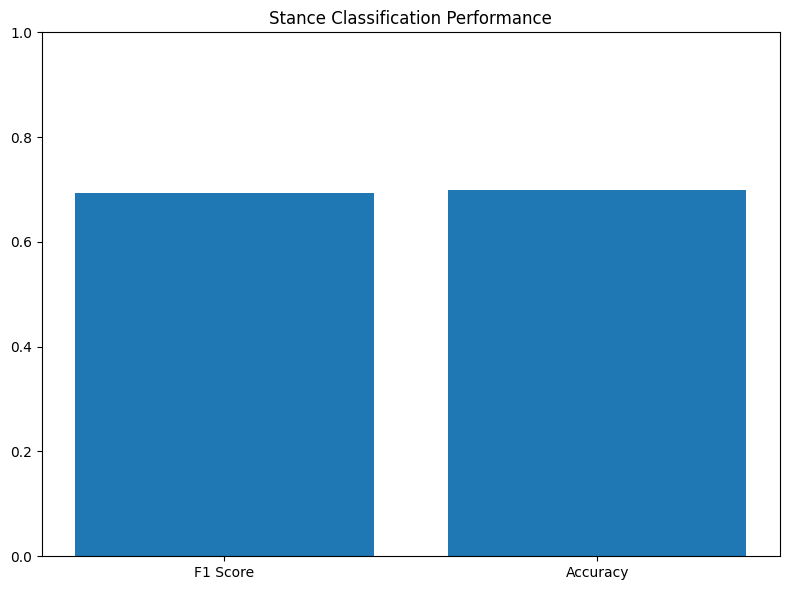

In [8]:
# 결과 시각화
plt.figure(figsize=(8, 6))
stance_metrics = ['F1 Score', 'Accuracy']
stance_values = [results['stance_report']['weighted avg']['f1-score'], 
                results['stance_report']['accuracy']]
plt.bar(stance_metrics, stance_values)
plt.title('Stance Classification Performance')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('./baseline_results/baseline_performance.png')
plt.show()